Here I would go through active learning process step by step, in order to observe model's behaviour.

In [106]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm

from src import model, data, train, visualization, active_learning

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
init_size = 1000
weight_regularization, dropout_regularization = 1e-5, 1e-3

### Preparing the data

`x_pool` and `y_pool` are sets from which I would draw examples for training during each active learning step.

In [108]:
x_train, y_train = data.prepare_data('./data/train_32x32.mat')
x_test, y_test = data.prepare_data('./data/test_32x32.mat')

test_dataset = data.SVHNDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

split = int(0.8 * len(x_train))
x_train, y_train, x_val, y_val = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

val_dataset = data.SVHNDataset(x_val, y_val)
validation_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# x_pool is the pool from which I will draw examples for active learning
x_train, x_pool, y_train, y_pool = x_train[:init_size], x_train[init_size:], y_train[:init_size], y_train[init_size:]

train_dataset = data.SVHNDataset(x_train, y_train)

loss_fn = torch.nn.CrossEntropyLoss()

len(train_dataset), len(x_pool), len(val_dataset), len(test_dataset)

(1000, 36272, 9318, 15950)

# Training of the initial model

For the first model I use 1000 random examples from the dataset.

In [109]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = model.ConcreteDropoutCNN(weight_regularization, dropout_regularization).to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 200, loss_fn, optimizer, disable_logs=True)

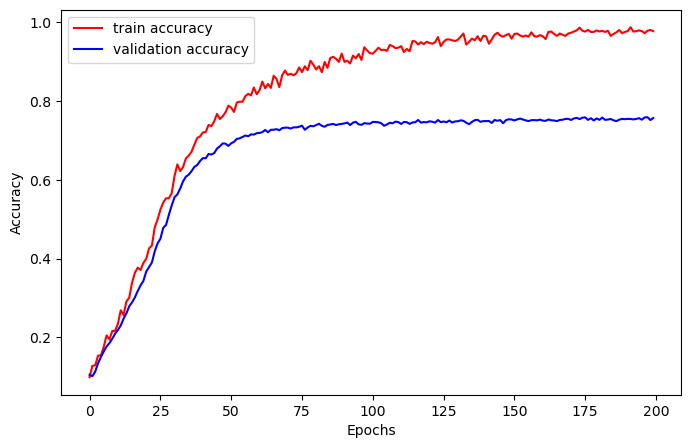

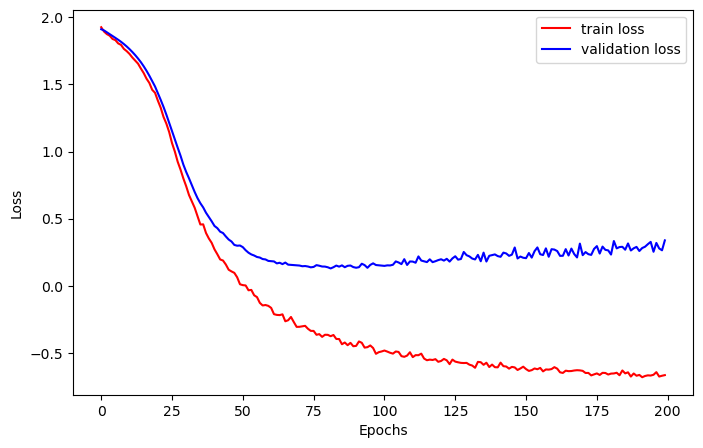

In [110]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [111]:
trained_model = model.ConcreteDropoutCNN(weight_regularization, dropout_regularization).to(device)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 74.5831%, test loss: 1.1621


That's a good result for just 1000 random examples!

Let's see what is going on with the dropout layers.

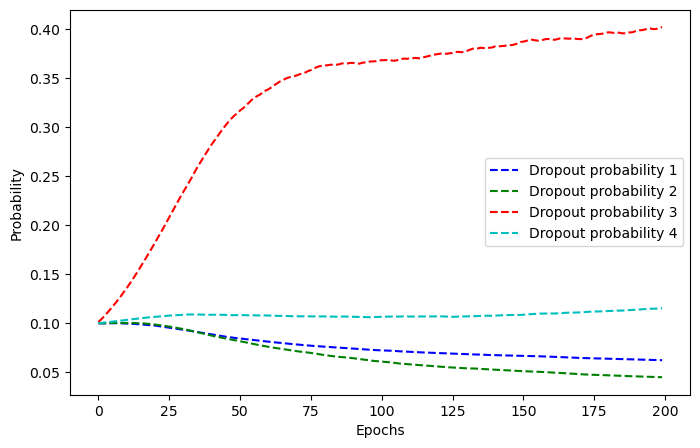

In [112]:
visualization.plot_dropout_change(history['probs'])

# Active learning step

First I need to calculate uncertainty for examples in the training pool.

In [113]:
uncertainty_pool = active_learning.montecarlo_entropy(trained_model, x_pool, num_classes=10, t=50)
uncertainty_pool.shape, uncertainty_pool[:5]

(torch.Size([36272]), tensor([1.5665, 0.9071, 0.5795, 0.7916, 0.5866]))

Next step is to extract 1000 examples with the biggest uncertainty.

In [114]:
most_uncertain = torch.topk(uncertainty_pool, 1000, sorted=False)
most_uncertain[0][:5], most_uncertain[1][:5]

(tensor([1.8547, 1.8993, 1.9301, 1.8907, 1.9103]),
 tensor([ 7638, 28911, 28864, 28836, 31373]))

Now I need to add those examples into training dataset and remove them from the pool.

In [115]:
train_dataset.extend(np.take(x_pool, most_uncertain[1], axis=0), np.take(y_pool, most_uncertain[1], axis=0))
x_pool = np.delete(x_pool, most_uncertain[1], axis=0)
y_pool = np.delete(y_pool, most_uncertain[1], axis=0)


len(train_dataset), len(x_pool), len(val_dataset), len(test_dataset)

(2000, 35272, 9318, 15950)

Now I can do the next active learning step in order to see, what changes.

In [116]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = model.ConcreteDropoutCNN(weight_regularization, dropout_regularization).to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 200, loss_fn, optimizer, disable_logs=True)

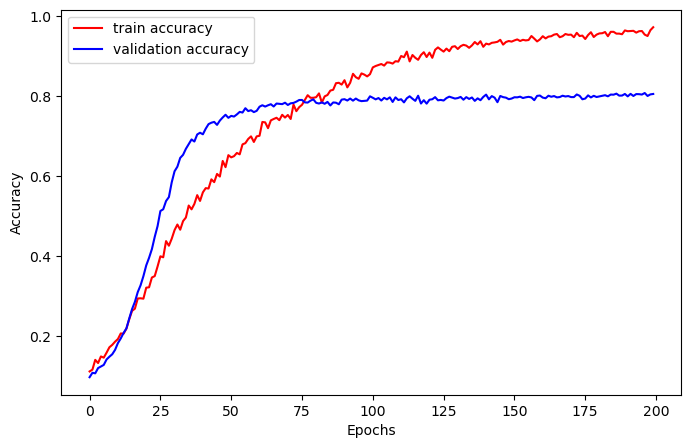

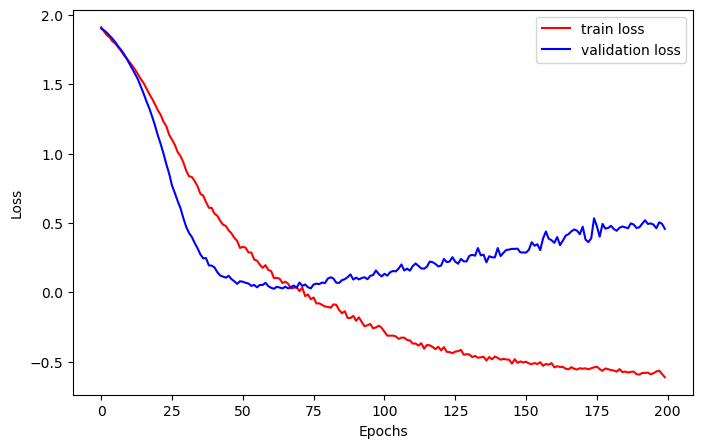

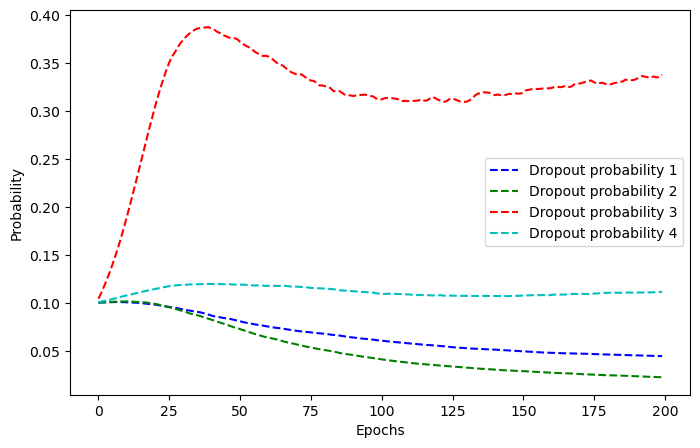

In [117]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])
visualization.plot_dropout_change(history['probs'])

In [118]:
trained_model = model.ConcreteDropoutCNN(weight_regularization, dropout_regularization).to(device)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 79.3292%, test loss: 1.3285


Model overfits faster, but the performance is better.

# Doing multiple steps

Next I perform 10 active learning steps in order to collect data on the process.

In [119]:
params = {
    'weight_regularization': weight_regularization,
    'dropout_regularization': dropout_regularization,
}

x_train, y_train = data.prepare_data('./data/train_32x32.mat')
x_test, y_test = data.prepare_data('./data/test_32x32.mat')

ac = active_learning.ActiveLearning(model.ConcreteDropoutCNN, params, x_train, y_train, x_test, y_test, active_learning.montecarlo_entropy,
                                    initial_train_size=1000, sample_batch_size=1000, device=device)
for _ in tqdm(range(10)):
    ac.step()

  0%|          | 0/10 [00:00<?, ?it/s]

After this I can see, what was the highest accuracy achieved on test set at every active learning step.

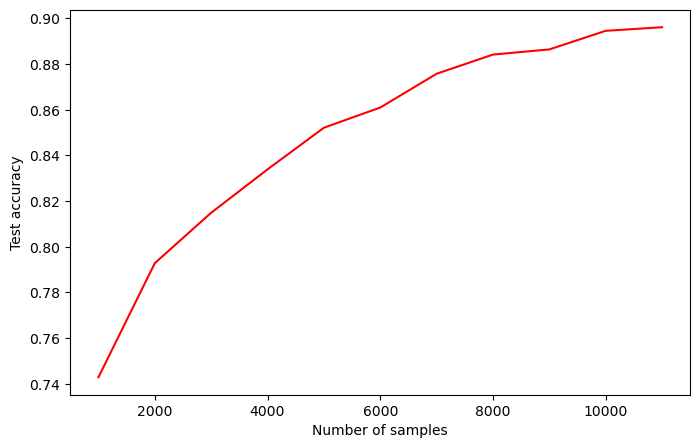

In [123]:
visualization.plot_accuracy_budget_curves(ac.active_learning_process)

Things are looking good, accuracy goes up. Now I can check, what was the highest accuracy achieved and with what budget (I know, the last one is pretty clear by the graph, but it won't be on a longer tests).

In [132]:
max_accuracy, best_budget = active_learning.max_accuracy(ac.active_learning_process)
print(f'Best test accuracy: {max_accuracy * 100:.4f}%, is achieved after training on {best_budget} samples')

Best test accuracy: 89.6176%, is achieved after training on 11000 samples


The next metric I want to look at is *True performance of the selection strategy*.

Proposed at [Statistical comparisons of active learning strategies over multiple datasets](https://www.sciencedirect.com/science/article/pii/S0950705118300492) it calculates the difference between relative performance gain and relative performance loss during active learning.

In this case, obviously, there's no performance loss, but this metric will still be useful further down the line.

In [133]:
active_learning.selection_strategy_performance(ac.active_learning_process)

11.749147512308257

This number doesn't tell much (is it good? is it bad?), but it will when I will compare different sampling strategies for active learning with each other.

Meanwhile, I can also look at the training history of the last active learning step.

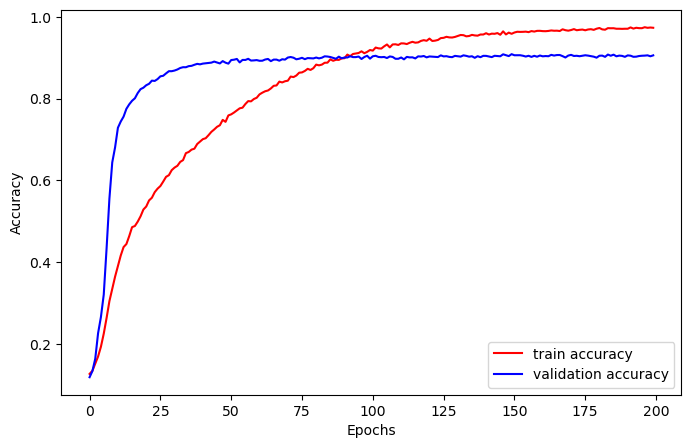

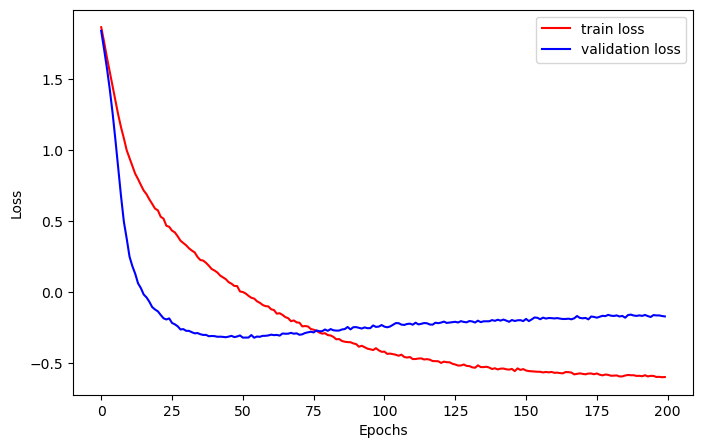

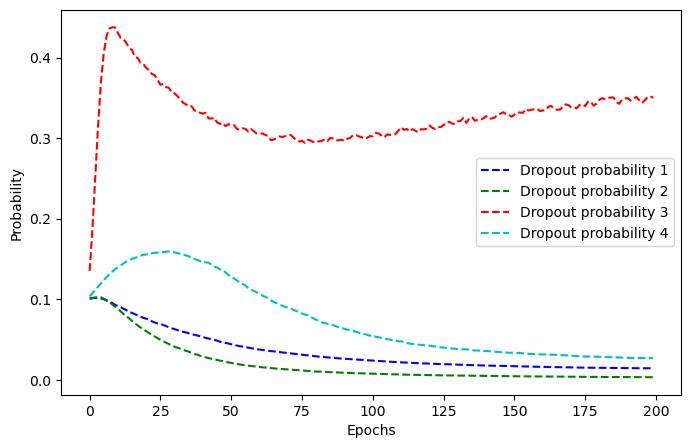

In [134]:
history = ac.history
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])
visualization.plot_dropout_change(history['probs'])

Everything seems in order, I am ready to finally train models for real.